In [1]:
!pip install optuna
!pip install optuna-integration
!pip install missingno
!pip install catboost


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from scipy import stats as st

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna
from optuna.integration import OptunaSearchCV
from optuna.visualization import plot_contour
from catboost import CatBoostRegressor
import missingno as msno


**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
1. качество предсказания;
2. время обучения модели;
3. время предсказания модели.

**В данной работе нам требуется:**

1. изучить датасет
2. сделать предобработку(избавиться от дубликатов, пустных значений)
3. провести исследовательский анализ данных.
4. провести корреляционный анализ признаков.
5. подготовить выборки для обучения моделей.
6. обучить разные модели.
7. проанализировать время обучения, время предсказания и качество моделей
8. опираясь на критерии заказчика, выберать лучшую модель, проверить её качество на тестовой выборке.

### Шаг 1. Загрузка данных

Проведем загрузку данных:

In [3]:
try:
    autos = pd.read_csv('datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:   
    autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])


In [4]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

**Вывод: Данные соответсвуют описанию и готовы к предобработке.**

### Шаг 2. Изучение данных

Проверка на дубликаты:

In [6]:
autos.duplicated().sum()

4

Всего 4 дубликата, удалим их:

In [7]:
autos.drop_duplicates(inplace=True)

In [8]:
autos.duplicated().sum()

0

Проверим на неявныее дубликаты:

In [9]:
autos.VehicleType.unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [10]:
autos.Model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [11]:
autos.FuelType.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [12]:
autos.Brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Проверка на пустые значения:

In [13]:
missing_values = autos.isnull().sum()
missing_values_percentages = round((missing_values / len(autos)) * 100, 2)

missing_values_table = pd.concat([missing_values, missing_values_percentages], axis=1)
missing_values_table.columns = ['Количество пропусков', 'Процентное соотношение']

print(missing_values_table)

                   Количество пропусков  Процентное соотношение
DateCrawled                           0                    0.00
Price                                 0                    0.00
VehicleType                       37490                   10.58
RegistrationYear                      0                    0.00
Gearbox                           19833                    5.60
Power                                 0                    0.00
Model                             19705                    5.56
Kilometer                             0                    0.00
RegistrationMonth                     0                    0.00
FuelType                          32895                    9.28
Brand                                 0                    0.00
Repaired                          71154                   20.08
DateCreated                           0                    0.00
NumberOfPictures                      0                    0.00
PostalCode                            0 

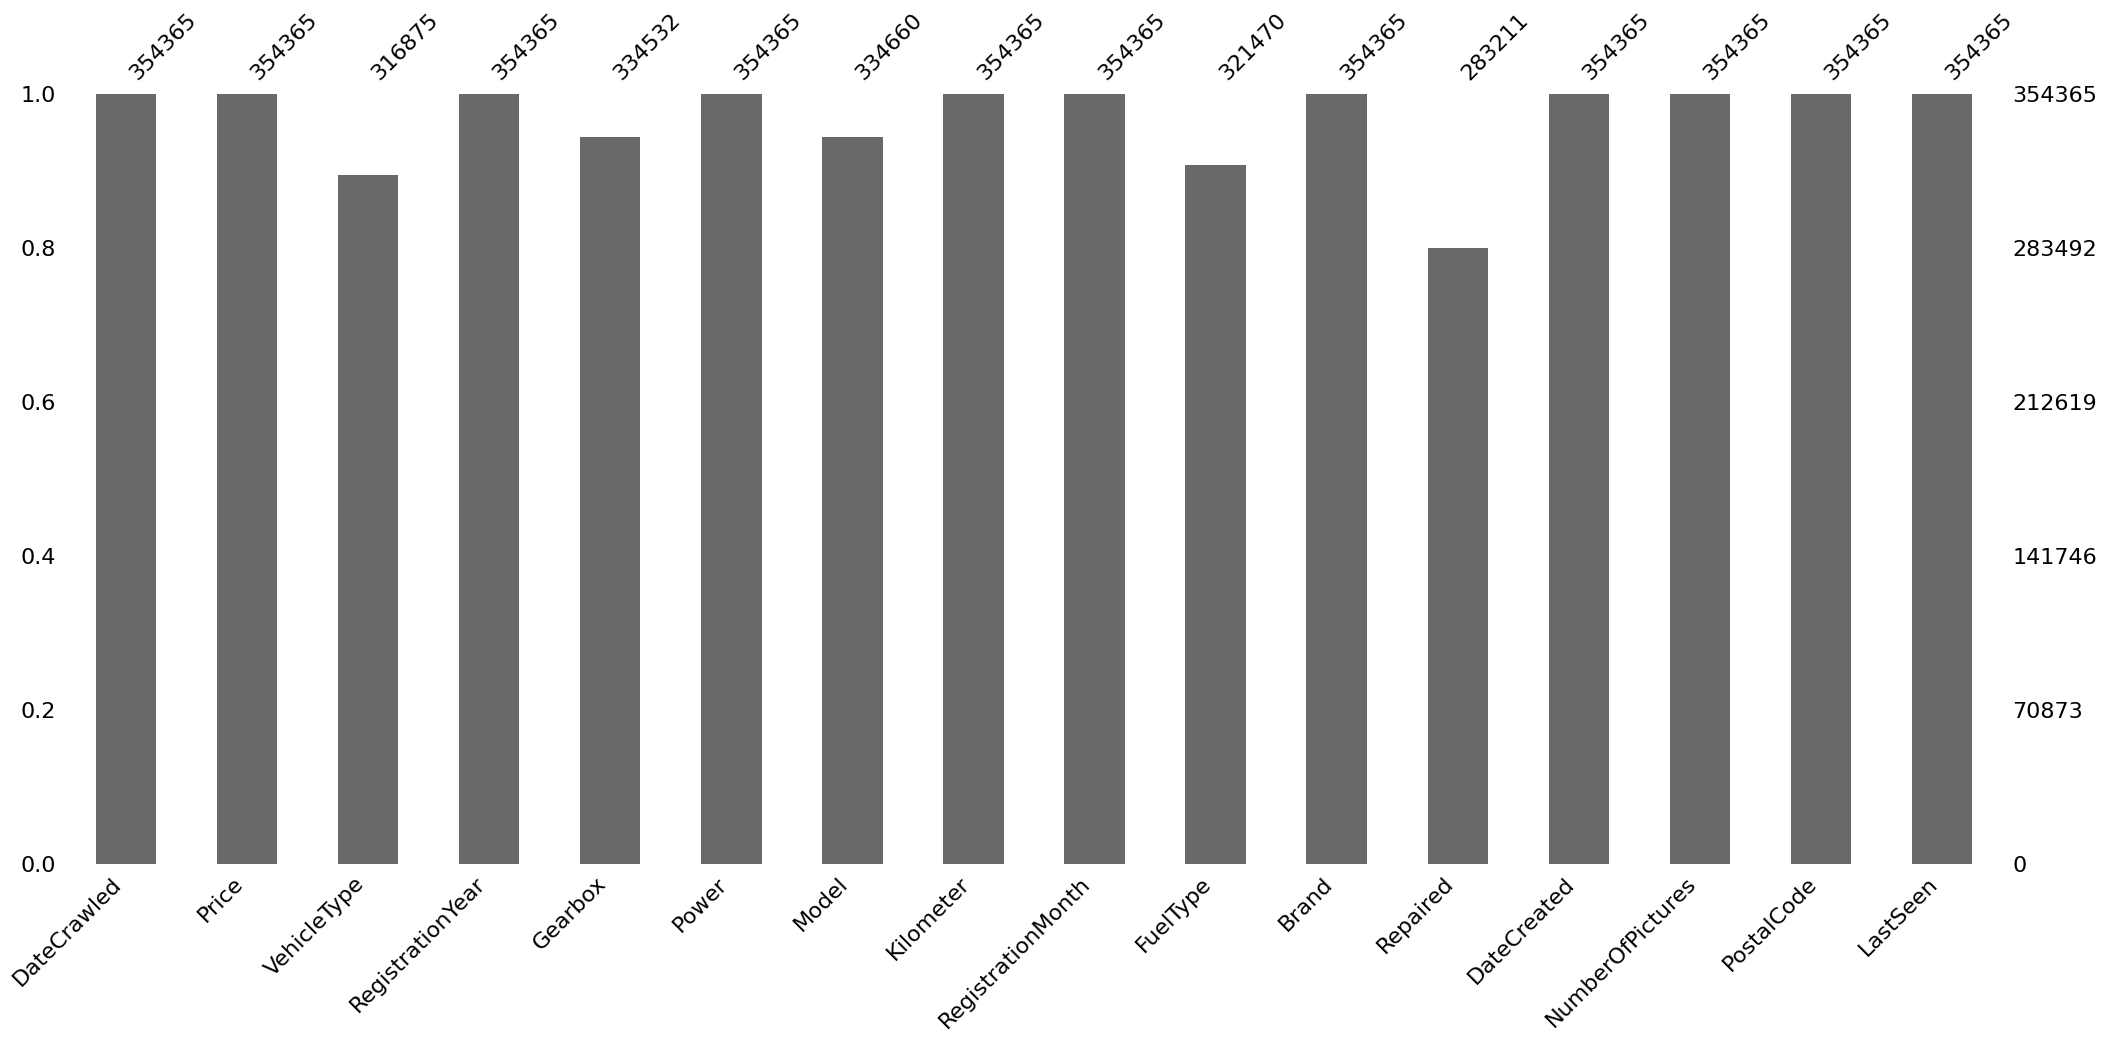

In [14]:
msno.bar(autos);

В некоторых столбцах присутствуют пропуски. Просто так их удалить не получится, так как их слишком много. Поэтому заменим пропуски на часто встречающимся значением:

In [15]:
autos.fillna(autos.mode().iloc[0], inplace=True)

In [16]:
missing_values = autos.isnull().sum()
missing_values_percentages = round((missing_values / len(autos)) * 100, 2)

missing_values_table = pd.concat([missing_values, missing_values_percentages], axis=1)
missing_values_table.columns = ['Количество пропусков', 'Процентное соотношение']

print(missing_values_table)

                   Количество пропусков  Процентное соотношение
DateCrawled                           0                     0.0
Price                                 0                     0.0
VehicleType                           0                     0.0
RegistrationYear                      0                     0.0
Gearbox                               0                     0.0
Power                                 0                     0.0
Model                                 0                     0.0
Kilometer                             0                     0.0
RegistrationMonth                     0                     0.0
FuelType                              0                     0.0
Brand                                 0                     0.0
Repaired                              0                     0.0
DateCreated                           0                     0.0
NumberOfPictures                      0                     0.0
PostalCode                            0 

In [17]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


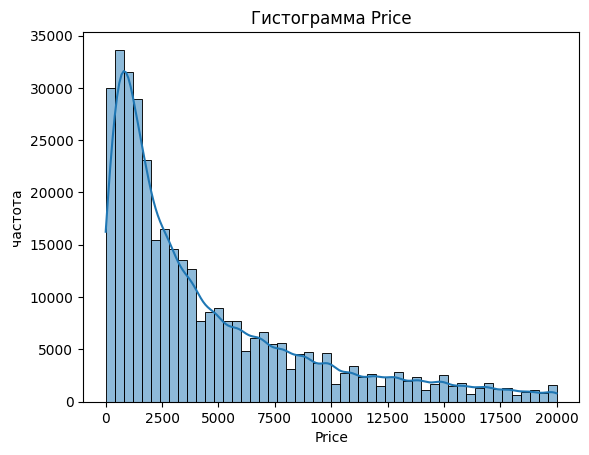

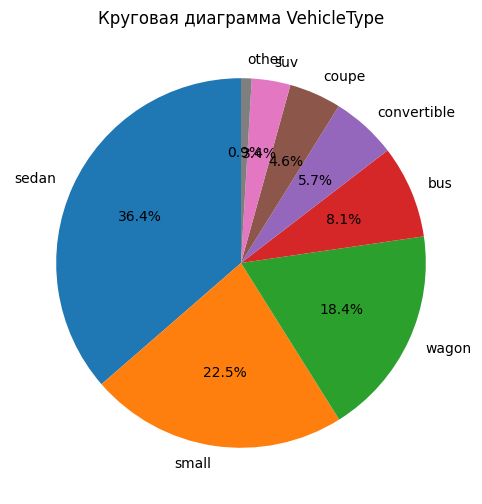

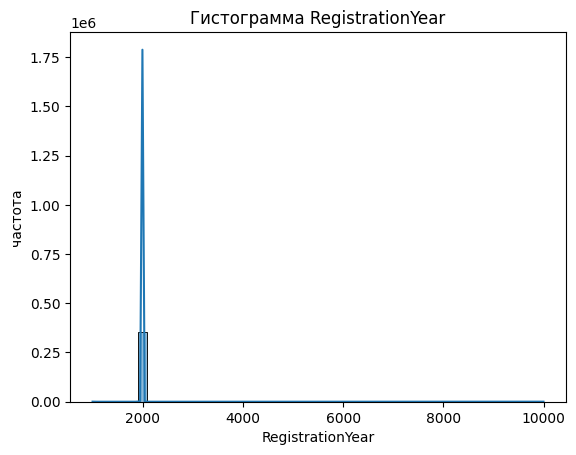

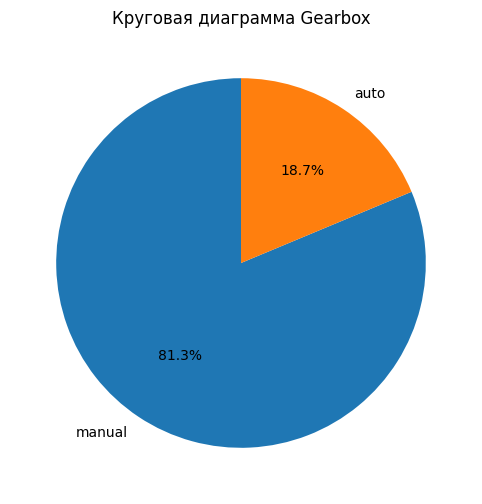

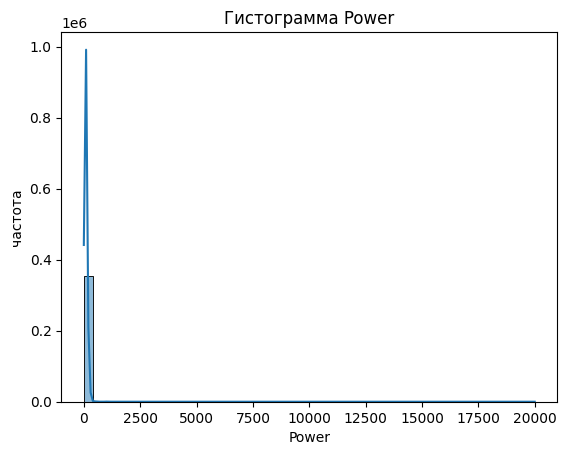

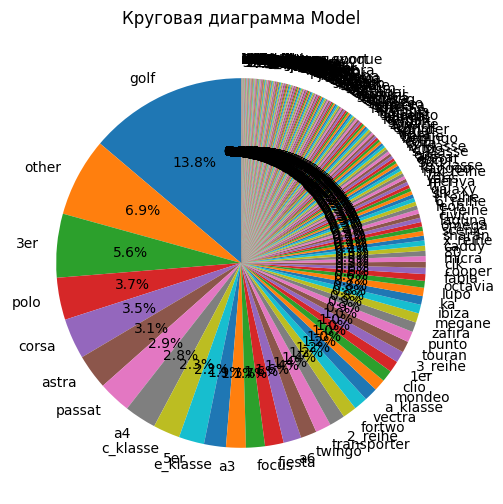

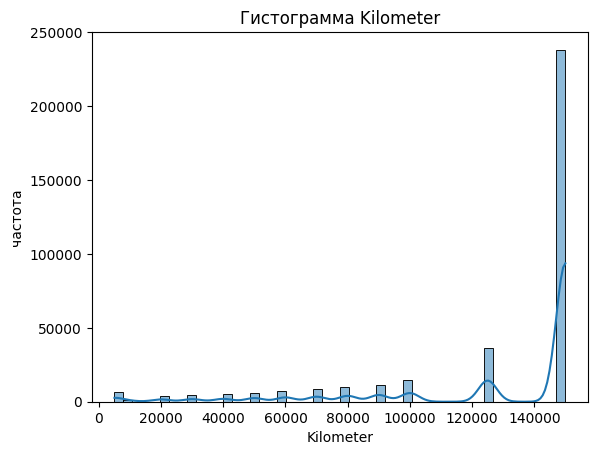

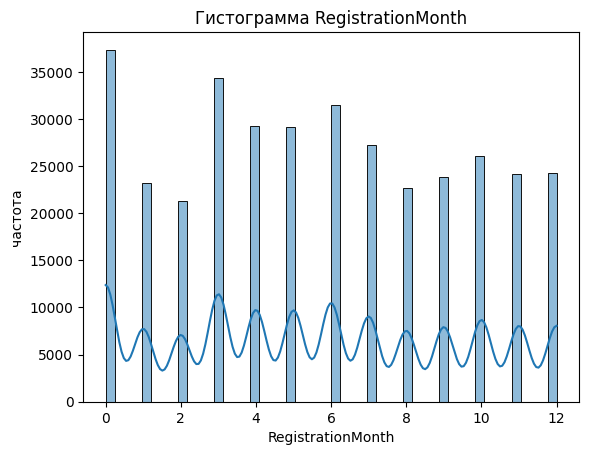

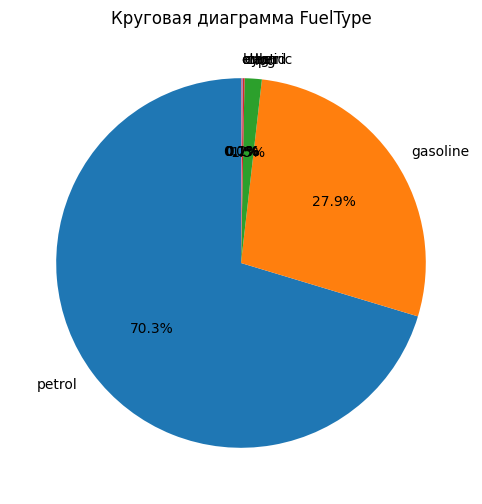

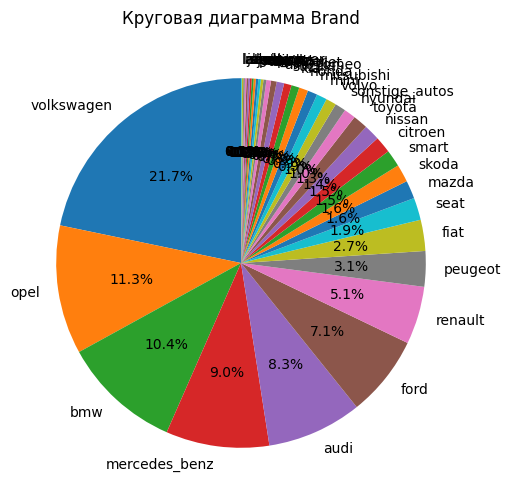

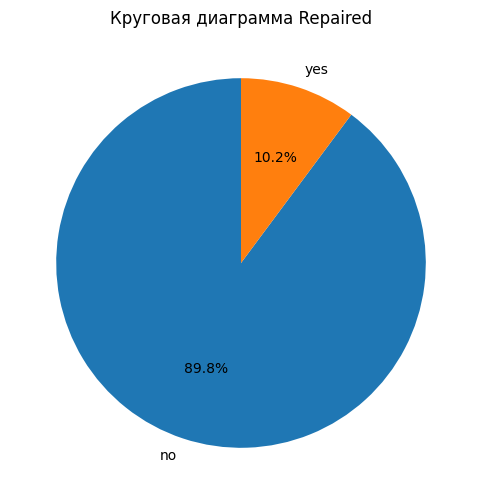

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


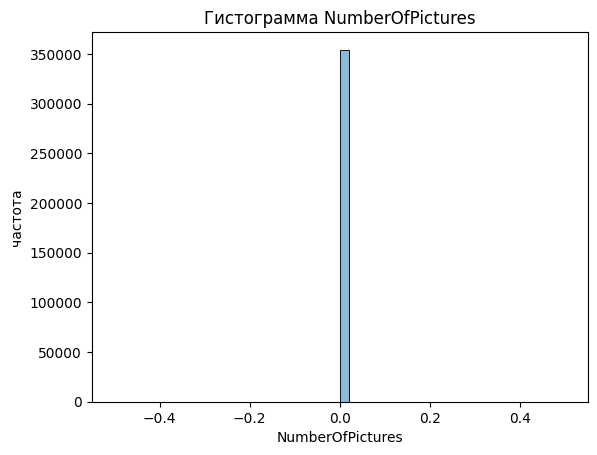

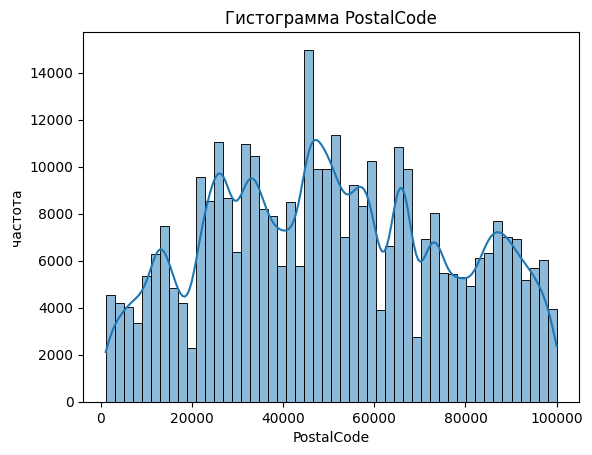

In [18]:
def plot_builder(df):
    for column in df:
        if column != 'id' and column != 'DateCrawled' and column != 'DateCreated'and column != 'LastSeen' :
            if df[column].dtype == 'int64' or df[column].dtype == 'float64':
                plt.figure()
                sns.histplot(data=df[column], bins=50, kde=True)
                plt.title(f'Гистограмма {column}')
                plt.xlabel(column)
                plt.ylabel('частота')
                plt.show()
            else:
                plt.figure(figsize=(10, 6))
                value_counts = df[column].value_counts()
                plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%',startangle=90)
                plt.title(f'Круговая диаграмма {column}')
                plt.show()

plot_builder(autos)

Разберем Price:

<AxesSubplot:>

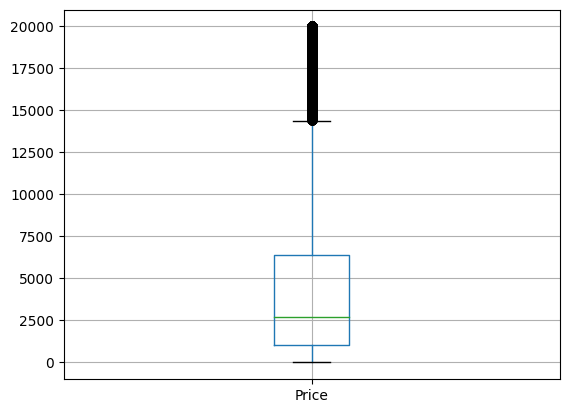

In [19]:
autos.boxplot('Price')

Врядли в наше время машина может стоить дешевле 500$. Поэтому удалим аномальные значения:

<AxesSubplot:>

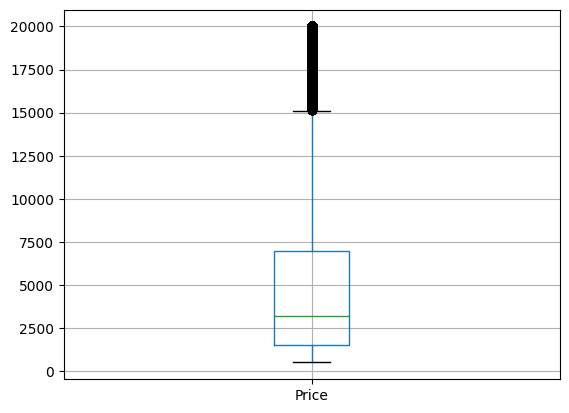

In [20]:
autos = autos[autos['Price'] >= 500]
autos.boxplot('Price')

Разберем год регистрации:

<AxesSubplot:>

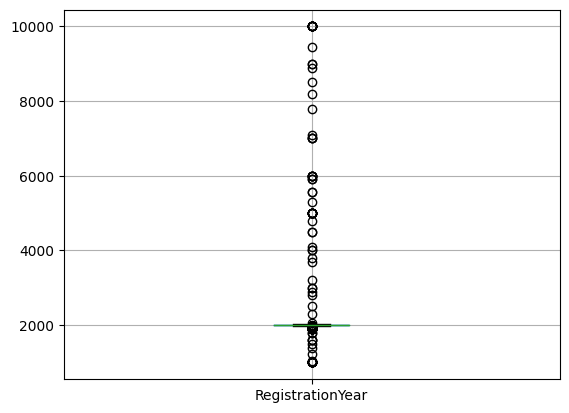

In [21]:
autos.boxplot('RegistrationYear')

In [22]:
autos['RegistrationYear'].describe()

count    318311.000000
mean       2004.164672
std          65.378165
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Год выгрузки базы 2016. Нужно удалить аномальные значения из столбца RegistrationYear. В то же время, первый автомобиль был изобретен в 1672, следовательно можно убрать все значения меньше 1700.

In [23]:
autos = autos[(autos['RegistrationYear'] <= 2016) & (autos['RegistrationYear'] >= 1700)]

<AxesSubplot:>

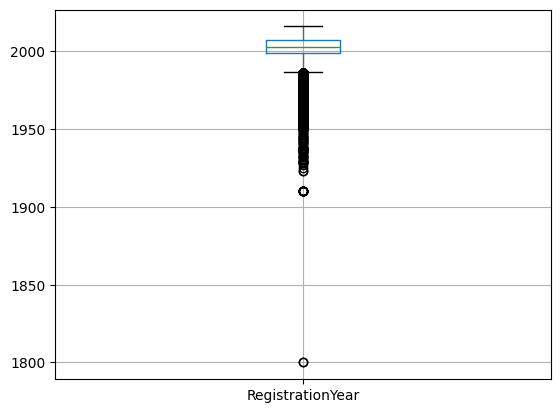

In [24]:
autos.boxplot('RegistrationYear')

Даже меньше 1990 года встречается очень мало машин. Удалим все значения меньше 1990 года:

<AxesSubplot:>

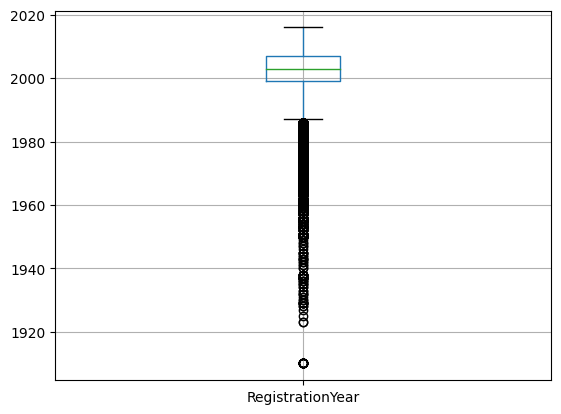

In [25]:
autos = autos[(autos['RegistrationYear'] <= 2016) & (autos['RegistrationYear'] >= 1900)]
autos.boxplot('RegistrationYear')

Разберем столбец с лошадиными силами:

<AxesSubplot:>

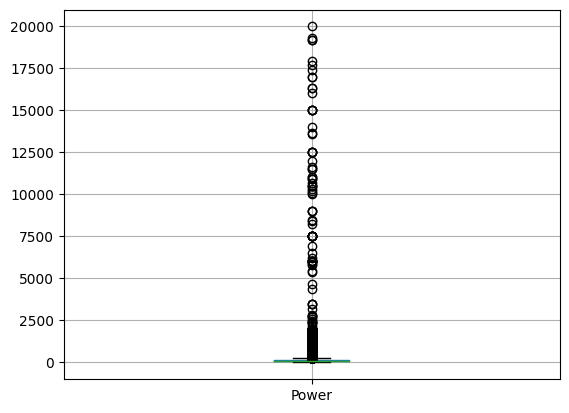

In [26]:
autos.boxplot('Power')

На данный момент не продаются машины с лошадиными силами больше 1500 и меньше 30. Так что очистим аномальные значения:

<AxesSubplot:>

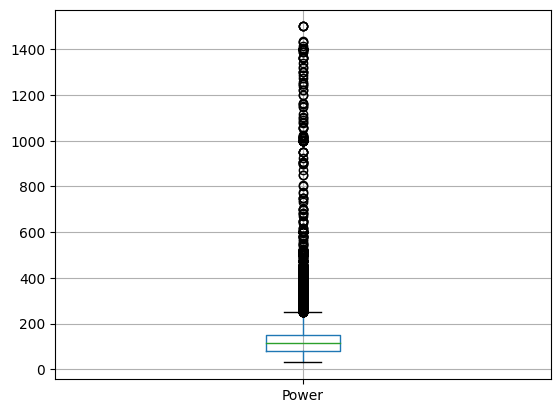

In [27]:
autos = autos[(autos['Power'] <= 1500) & (autos['Power'] >= 30)]
autos.boxplot('Power')

Разберем тип мотора:

In [28]:
autos.FuelType.unique()

array(['gasoline', 'petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

gasoline и petrol это одно и то же. Заменим на одно значение:

In [29]:
autos['FuelType'] = autos['FuelType'].replace('gasoline', 'petrol')

In [30]:
autos.FuelType.unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Проведем корреляционный анализ.

Судя по боксплотам, данные имеют аномальные значения, поэтому будем использовать метод Спирмена:

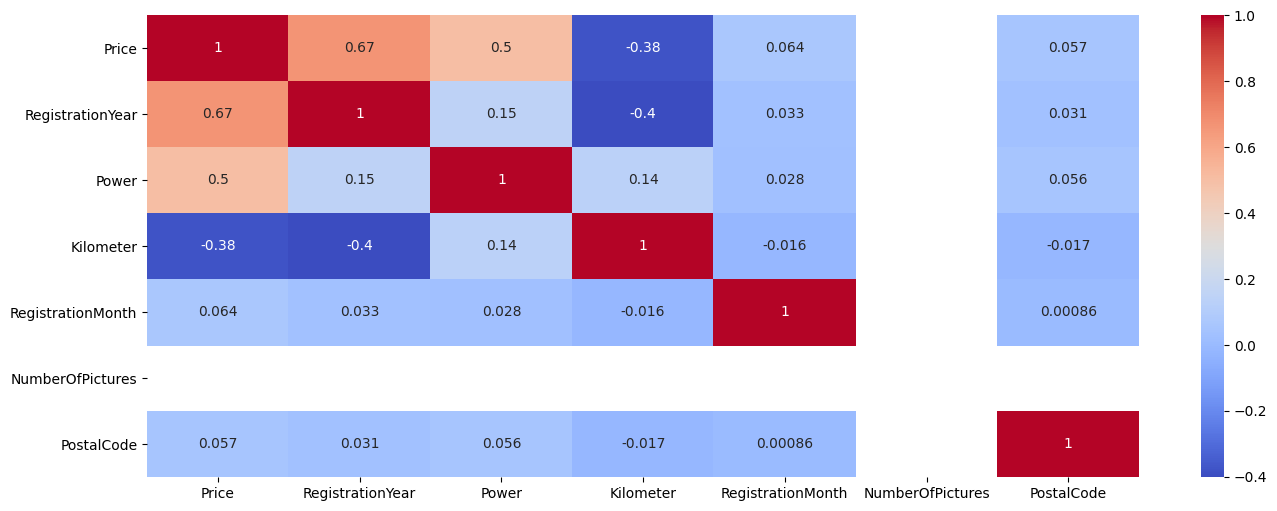

In [31]:
plt.figure(figsize=(16, 6))
sns.heatmap(autos.corr(method='spearman'), annot=True, cmap='coolwarm');

In [32]:
autos = autos.drop(['RegistrationMonth', 'PostalCode', 'NumberOfPictures'], axis=1)
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278853 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DateCrawled       278853 non-null  datetime64[ns]
 1   Price             278853 non-null  int64         
 2   VehicleType       278853 non-null  object        
 3   RegistrationYear  278853 non-null  int64         
 4   Gearbox           278853 non-null  object        
 5   Power             278853 non-null  int64         
 6   Model             278853 non-null  object        
 7   Kilometer         278853 non-null  int64         
 8   FuelType          278853 non-null  object        
 9   Brand             278853 non-null  object        
 10  Repaired          278853 non-null  object        
 11  DateCreated       278853 non-null  datetime64[ns]
 12  LastSeen          278853 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(4), object(6)
memory usage: 29.

In [33]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
        # Размер занимаемой памяти до оптимизации (в Мб)
        before_size = df.memory_usage().sum() / 1024**2    
        for column in df.columns:
            column_type = df[column].dtypes
            if column_type in numerics:
                column_min = df[column].min()
                column_max = df[column].max()
                if str(column_type).startswith('int'):
                    if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                        df[column] = df[column].astype(np.int8)
                    elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                        df[column] = df[column].astype(np.int16)
                    elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                        df[column] = df[column].astype(np.int32)
                    elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                        df[column] = df[column].astype(np.int64)  
                else:
                    if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                        df[column] = df[column].astype(np.float32)
                    else:
                        df[column] = df[column].astype(np.float64)    
        # Размер занимаемой памяти после оптимизации (в Мб)
        after_size = df.memory_usage().sum() / 1024**2
        if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                             .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
        return df
optimize_memory_usage(autos, print_size=True)

Размер использования памяти: до 29.78 Mb - после 23.93 Mb (19.6%)


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,golf,125000,petrol,audi,yes,2016-03-24,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no,2016-03-14,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,2016-03-31,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-04,2016-04-06 19:17:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,2016-03-09 13:37:43,5250,sedan,2016,auto,150,159,150000,petrol,alfa_romeo,no,2016-03-09,2016-03-13 01:44:13
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,2016-03-19,2016-03-19 20:44:43
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,2016-03-05,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no,2016-03-19,2016-04-07 07:15:26


**Вывод: Удалены дубликаты и заполнены пропуски часто встречаемыми значениями. Так же сделан корреляционный анализ. Мультиколлинеарности не замечено.**

### Шаг 3. Подготовка выборок для обучения моделей.

In [34]:
num_columns = ['RegistrationYear', 'Power', 'Kilometer'] 
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
ord_categories = [autos[col].dropna().unique().tolist() for col in cat_columns]

RANDOM_STATE = 42
TRAIN_SIZE = 0.6
VALIDATION_SIZE = 0.2
TEST_SIZE = 0.2

X = autos.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
y = autos['Price']


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=(1 - TRAIN_SIZE), random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(TEST_SIZE / (VALIDATION_SIZE + TEST_SIZE)), random_state=RANDOM_STATE
)

### Шаг 4. Обучение моделей.

In [35]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=ord_categories,
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'scaler', 
            StandardScaler()
        )
    ]
)
data_preprocessor = ColumnTransformer(
    [   
        ('ord', ord_pipe, cat_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_distributions = {
    'models__max_depth': optuna.distributions.IntDistribution(1, 10),
    'models__min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'models__min_samples_leaf': optuna.distributions.IntDistribution(1, 10),
    'models__max_features': optuna.distributions.FloatDistribution(0.1, 1.0),
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

optuna_search = OptunaSearchCV(
    pipe_final,
    param_distributions,
    cv=5,
    scoring=rmse_scorer,
    n_trials=15,
    n_jobs=-1)

start_train = time.time()
optuna_search.fit(X_train, y_train)
end_train = time.time()
training_time = end_train - start_train

start_predict = time.time()
y_pred_1 = optuna_search.predict(X_val)
end_predict = time.time()
prediction_time = end_predict - start_predict

print('Лучшая модель и её параметры:\n\n', optuna_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', optuna_search.best_score_)
print(f'Время обучения: {training_time} секунд')
print(f'Время предсказания: {prediction_time} секунд')

C:\Users\vanya\AppData\Local\Temp\ipykernel_7664\3047061980.py:57: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-05-25 20:27:54,135] A new study created in memory with name: no-name-20bb5b52-93ce-4675-a5c9-c9ee48e5f655


[I 2024-05-25 20:28:13,497] Trial 1 finished with value: -4039.9048737581325 and parameters: {'models__max_depth': 4, 'models__min_samples_split': 7, 'models__min_samples_leaf': 8, 'models__max_features': 0.1337236204303353}. Best is trial 1 with value: -4039.9048737581325.
[I 2024-05-25 20:28:13,508] Trial 12 finished with value: -2930.0647957501824 and parameters: {'models__max_depth': 5, 'models__min_samples_split': 4, 'models__min_samples_leaf': 9, 'models__max_features': 0.5042545649773595}. Best is trial 12 with value: -2930.0647957501824.
[I 2024-05-25 20:28:13,517] Trial 2 finished with value: -3659.3144889554437 and parameters: {'models__max_depth': 1, 'models__min_samples_split': 3, 'models__min_samples_leaf': 8, 'models__max_features': 0.8867625821623141}. Best is trial 12 with value: -2930.0647957501824.
[I 2024-05-25 20:28:13,547] Trial 3 finished with value: -2954.1034260301117 and parameters: {'models__max_depth': 10, 'models__min_samples_split': 9, 'models__min_samples_

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['coupe',
                                                                                               'suv',
                                                                                               'small',
                                                                                               'sedan',
                                                                                               'convertible',
                

In [36]:
fig = plot_contour(optuna_search.study_, params=['models__min_samples_split', 'models__max_depth'])
fig.show()

In [37]:

pipe_final_catboost = Pipeline([
    ('models', CatBoostRegressor(
        random_state=RANDOM_STATE,
        verbose=3,
        cat_features=cat_columns,
        # task_type='GPU'  
    ))
])

param_distributions_catboost = {
    'models__iterations': optuna.distributions.IntDistribution(10, 40),
    'models__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3),
    'models__depth': optuna.distributions.IntDistribution(3, 10),
    'models__l2_leaf_reg': optuna.distributions.IntDistribution(1, 10),
}

optuna_search_catboost = OptunaSearchCV(
    pipe_final_catboost,
    param_distributions_catboost,
    cv=5,
    scoring=rmse_scorer,
    n_trials=15,
    n_jobs=-1
)

start_train = time.time()
optuna_search_catboost.fit(X_train, y_train)
end_train = time.time()
training_time = end_train - start_train

start_predict = time.time()
y_pred_catboost = optuna_search_catboost.predict(X_val)
end_predict = time.time()
prediction_time = end_predict - start_predict

print('Лучшая модель и её параметры:\n\n', optuna_search_catboost.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', optuna_search_catboost.best_score_)
print(f'Время обучения: {training_time} секунд')
print(f'Время предсказания: {prediction_time} секунд')

C:\Users\vanya\AppData\Local\Temp\ipykernel_7664\3683836254.py:22: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2024-05-25 20:28:14,623] A new study created in memory with name: no-name-5aa18310-2244-4f17-9c0c-06bc3fa044b9


0:	learn: 4174.5852282	total: 1.85s	remaining: 50.1s
0:	learn: 4076.0108377	total: 2.43s	remaining: 46.1s
0:	learn: 4374.5421461	total: 2.38s	remaining: 21.5s
0:	learn: 4539.9535018	total: 1.69s	remaining: 27s
0:	learn: 3992.8871251	total: 1.18s	remaining: 42.4s
0:	learn: 4194.7976990	total: 1.41s	remaining: 46.5s
0:	learn: 4195.5526592	total: 2.15s	remaining: 1m 12s
0:	learn: 3956.4856125	total: 1.27s	remaining: 15.2s
0:	learn: 4218.9348527	total: 837ms	remaining: 13.4s
0:	learn: 4347.9924432	total: 963ms	remaining: 14.4s
0:	learn: 4190.1705849	total: 510ms	remaining: 12.7s
0:	learn: 3943.9677599	total: 2.72s	remaining: 1m 21s
0:	learn: 4438.5999535	total: 537ms	remaining: 19.3s
0:	learn: 4161.7283358	total: 362ms	remaining: 7.6s
3:	learn: 3262.6065956	total: 2.49s	remaining: 14.9s
3:	learn: 3799.1144880	total: 2.76s	remaining: 4.14s
3:	learn: 4344.7933108	total: 2.09s	remaining: 6.8s
0:	learn: 4483.4192108	total: 231ms	remaining: 8.08s
3:	learn: 2935.0832907	total: 1.6s	remaining: 13

[I 2024-05-25 20:28:35,845] Trial 2 finished with value: -3052.7410725217806 and parameters: {'models__iterations': 10, 'models__learning_rate': 0.08171078946251367, 'models__depth': 5, 'models__l2_leaf_reg': 2}. Best is trial 2 with value: -3052.7410725217806.


12:	learn: 2326.9254155	total: 2.65s	remaining: 4.28s
9:	learn: 2232.9535015	total: 2.97s	remaining: 2.97s
6:	learn: 2685.0662905	total: 1.99s	remaining: 4.26s

Power, bin=91 score 786538.1593
Power, bin=113 score 886844.9341
Power, bin=181 score 267862.6174

Gearbox, value=1 score 170200.7893
RegistrationYear, bin=76 score 212935.3706

12:	learn: 2282.0113452	total: 4.68s	remaining: 4.68s
15:	learn: 3719.4110879	total: 3.77s	remaining: 235ms
12:	learn: 2326.5280521	total: 3.9s	remaining: 1.2s
12:	learn: 2016.5759664	total: 4.52s	remaining: 0us
9:	learn: 2904.6539409	total: 1.63s	remaining: 977ms
12:	learn: 2038.6776569	total: 2.46s	remaining: 4.53s
16:	learn: 3676.8130197	total: 3.86s	remaining: 0us
15:	learn: 2167.4849524	total: 3.2s	remaining: 2.4s
15:	learn: 2187.8416331	total: 2.75s	remaining: 3.27s
15:	learn: 2197.3308889	total: 2.98s	remaining: 3.35s
9:	learn: 3599.6179763	total: 4.17s	remaining: 10.8s
9:	learn: 3327.5380862	total: 3.63s	remaining: 9.8s
15:	learn: 2144.8104970	t

[I 2024-05-25 20:28:40,992] Trial 5 finished with value: -2020.895009268069 and parameters: {'models__iterations': 13, 'models__learning_rate': 0.22359326390458617, 'models__depth': 6, 'models__l2_leaf_reg': 5}. Best is trial 5 with value: -2020.895009268069.


27:	learn: 2327.4799820	total: 7.61s	remaining: 2.44s
12:	learn: 2019.5165808	total: 2.66s	remaining: 0us
12:	learn: 2327.6801758	total: 2.5s	remaining: 768ms
30:	learn: 1726.4267750	total: 9.75s	remaining: 0us
21:	learn: 1885.4436393	total: 6.07s	remaining: 0us
15:	learn: 2180.5809908	total: 2.62s	remaining: 164ms
27:	learn: 2612.9724092	total: 8.44s	remaining: 2.41s
9:	learn: 2458.1825472	total: 1.25s	remaining: 2.01s
9:	learn: 2230.4999643	total: 1.75s	remaining: 1.75s
9:	learn: 2905.5226009	total: 2.03s	remaining: 1.22s
12:	learn: 2282.9270602	total: 1.55s	remaining: 1.79s
15:	learn: 3716.8492333	total: 2.86s	remaining: 179ms
16:	learn: 3674.5929595	total: 2.92s	remaining: 0us
30:	learn: 2245.3144677	total: 7.89s	remaining: 1.53s
{VehicleType} pr1 tb0 type0, border=7 score 292699.2069
RegistrationYear, bin=65 score 343586.3716
Kilometer, bin=11 score 265766.6012


{VehicleType} pr1 tb0 type0, border=8 score 512050.1046
RegistrationYear, bin=64 score 205266.784
RegistrationYear, bin

[I 2024-05-25 20:28:42,126] Trial 6 finished with value: -3678.1409143156575 and parameters: {'models__iterations': 17, 'models__learning_rate': 0.023348738277507237, 'models__depth': 5, 'models__l2_leaf_reg': 6}. Best is trial 5 with value: -2020.895009268069.
[I 2024-05-25 20:28:42,146] Trial 11 finished with value: -2471.50561530201 and parameters: {'models__iterations': 16, 'models__learning_rate': 0.08426868959530942, 'models__depth': 7, 'models__l2_leaf_reg': 9}. Best is trial 5 with value: -2020.895009268069.


0:	learn: 4196.1183539	total: 57.5ms	remaining: 1.9s
33:	learn: 2178.5875351	total: 8.35s	remaining: 737ms
18:	learn: 2080.8990216	total: 2.01s	remaining: 951ms
36:	learn: 2118.6166404	total: 8.57s	remaining: 0us
3:	learn: 3321.6440985	total: 186ms	remaining: 1.4s
15:	learn: 2463.0139438	total: 2.61s	remaining: 0us
12:	learn: 2260.3568505	total: 1.65s	remaining: 1.65s
15:	learn: 1980.0670196	total: 2.34s	remaining: 585ms
21:	learn: 2029.4110258	total: 2.14s	remaining: 583ms
30:	learn: 2510.1891767	total: 8.87s	remaining: 1.43s
{Brand} pr0 tb0 type0, border=10 score 60781.29175
RegistrationYear, bin=72 score 83237.32978
{Model} pr1 tb0 type0, border=6 score 76299.76901
{Brand} pr1 tb0 type0, border=11 score 232869.8982
Object info sizes: 133849 9
{Brand} pr0 tb0 type0, border=6 score 255544.6358
RegistrationYear, bin=77 score 109338.9176
Kilometer, bin=11 score 89279.85037
Power, bin=120 score 472914.2739
Power, bin=193 score 411991.0759


[I 2024-05-25 20:28:42,156] Trial 7 finished with value: -2155.1534809825007 and parameters: {'models__iterations': 17, 'models__learning_rate': 0.13047012358558152, 'models__depth': 6, 'models__l2_leaf_reg': 1}. Best is trial 5 with value: -2020.895009268069.


0:	learn: 4197.0030709	total: 158ms	remaining: 5.39s
0:	learn: 3995.0649663	total: 331ms	remaining: 11.9s
12:	learn: 2316.0358882	total: 1.05s	remaining: 1.69s
27:	learn: 1965.4831282	total: 2.85s	remaining: 0us
18:	learn: 2053.4866920	total: 2.4s	remaining: 882ms
Power, bin=165 score 857431.0013
Power, bin=123 score 234873.4311
RegistrationYear, bin=74 score 1403796.186
Kilometer, bin=11 score 744032.2835
{Brand} pr1 tb0 type0, border=7 score 204254.0004
15:	learn: 2197.9655744	total: 1.58s	remaining: 1.77s
3:	learn: 3323.5626315	total: 835ms	remaining: 6.47s
33:	learn: 2421.5180783	total: 10.2s	remaining: 597ms
3:	learn: 2913.5697450	total: 1.04s	remaining: 8.59s
0:	learn: 3953.2718948	total: 669ms	remaining: 20.1s
0:	learn: 4162.5222947	total: 712ms	remaining: 15s
0:	learn: 4076.6385371	total: 235ms	remaining: 4.46s
0:	learn: 4448.9519969	total: 465ms	remaining: 16.7s
6:	learn: 2813.3293972	total: 1.49s	remaining: 5.94s
18:	learn: 2108.4908512	total: 2.24s	remaining: 1.77s
21:	learn

[I 2024-05-25 20:28:46,620] Trial 0 finished with value: -1916.6432835635692 and parameters: {'models__iterations': 20, 'models__learning_rate': 0.17585703654238227, 'models__depth': 7, 'models__l2_leaf_reg': 9}. Best is trial 0 with value: -1916.6432835635692.


30:	learn: 1839.4785748	total: 4.29s	remaining: 830ms
9:	learn: 2474.5914743	total: 1.19s	remaining: 1.9s
33:	learn: 1926.3625394	total: 4.12s	remaining: 121ms
18:	learn: 1935.4074526	total: 3.54s	remaining: 559ms
27:	learn: 1960.1715439	total: 2.6s	remaining: 0us
34:	learn: 1919.4581819	total: 4.19s	remaining: 0us
18:	learn: 2706.0854795	total: 3.27s	remaining: 3.1s
6:	learn: 2811.5703264	total: 594ms	remaining: 2.29s


12:	learn: 3383.8014321	total: 1.97s	remaining: 3.49s
12:	learn: 2269.5804243	total: 1.44s	remaining: 1.44s
33:	learn: 1826.9967405	total: 4.55s	remaining: 401ms
9:	learn: 2500.3149024	total: 767ms	remaining: 1.84s
18:	learn: 1792.6997795	total: 4.17s	remaining: 2.64s


[I 2024-05-25 20:28:47,107] Trial 1 finished with value: -1960.250231373512 and parameters: {'models__iterations': 28, 'models__learning_rate': 0.15449158331916105, 'models__depth': 5, 'models__l2_leaf_reg': 3}. Best is trial 0 with value: -1916.6432835635692.


36:	learn: 1814.8139461	total: 4.77s	remaining: 0us
21:	learn: 1878.1953160	total: 3.91s	remaining: 0us
15:	learn: 2144.7835808	total: 1.66s	remaining: 1.04s
21:	learn: 2553.0918234	total: 3.62s	remaining: 2.47s
15:	learn: 3189.5574875	total: 2.3s	remaining: 2.88s
12:	learn: 2314.7646280	total: 955ms	remaining: 1.54s
Kilometer, bin=11 score 508168.6582
RegistrationYear, bin=72 score 74481.75229

RegistrationYear, bin=65 score 536468.1756
18:	learn: 2053.8060009	total: 1.88s	remaining: 693ms
15:	learn: 2194.2691933	total: 1.14s	remaining: 1.28s
24:	learn: 2429.1387864	total: 3.95s	remaining: 1.9s
18:	learn: 3017.9778408	total: 2.61s	remaining: 2.34s
21:	learn: 1770.1978287	total: 4.57s	remaining: 1.87s
21:	learn: 1999.2447475	total: 2.06s	remaining: 374ms
{Model} pr0 tb0 type0, border=7 score 200480.0492
RegistrationYear, bin=64 score 62446.17797
RegistrationYear, bin=76 score 449820.8129
{Brand} pr0 tb0 type0, border=8 score 66536.47177
{Brand} pr0 tb0 type1, border=2 score 215497.0732

[I 2024-05-25 20:28:48,700] Trial 12 finished with value: -1946.9338834316181 and parameters: {'models__iterations': 26, 'models__learning_rate': 0.14069132779389662, 'models__depth': 6, 'models__l2_leaf_reg': 6}. Best is trial 0 with value: -1916.6432835635692.


3:	learn: 2901.4489606	total: 305ms	remaining: 2.52s
3:	learn: 3229.2647631	total: 599ms	remaining: 2.69s
30:	learn: 2244.4622501	total: 5.21s	remaining: 1.01s
9:	learn: 2501.8082335	total: 1.04s	remaining: 2.6s
24:	learn: 2745.3910919	total: 3.75s	remaining: 1.65s

RegistrationYear, bin=64 score 131133.4717
{Brand} pr1 tb0 type0, border=5 score 48717.43902

30:	learn: 1947.6419411	total: 2.63s	remaining: 255ms
6:	learn: 2392.9959929	total: 527ms	remaining: 2.26s
27:	learn: 1743.7910133	total: 6s	remaining: 642ms
12:	learn: 2315.8600993	total: 1.23s	remaining: 2.08s
33:	learn: 1930.3364916	total: 2.82s	remaining: 0us
6:	learn: 2684.4227301	total: 953ms	remaining: 2.04s
33:	learn: 2169.1185871	total: 5.55s	remaining: 489ms
9:	learn: 2156.8727332	total: 759ms	remaining: 2.05s
27:	learn: 2624.2045992	total: 4.07s	remaining: 1.16s
15:	learn: 2194.9870082	total: 1.4s	remaining: 1.66s
{Model} pr1 tb0 type0, border=6 score 34230.93319
{VehicleType} pr0 tb0 type1, border=6 score 271626.9116
Re

[I 2024-05-25 20:28:49,181] Trial 8 finished with value: -1935.0163349317118 and parameters: {'models__iterations': 34, 'models__learning_rate': 0.1472238452047201, 'models__depth': 5, 'models__l2_leaf_reg': 7}. Best is trial 0 with value: -1916.6432835635692.


RegistrationYear, bin=60 score 232301.3362
Repaired, value=1 score 328146.9513
{Brand} pr0 tb0 type0, border=6 score 367725.1709
{VehicleType} pr0 tb0 type1, border=13 score 58645.00772
{Brand} pr0 tb0 type1, border=4 score 261090.4811
{VehicleType} pr1 tb0 type0, border=8 score 397756.2314
RegistrationYear, bin=68 score 346159.9218
{Model} pr1 tb0 type0, border=9 score 96237.98715
{Brand} pr1 tb0 type0, border=5 score 339902.3855

{Brand} pr0 tb0 type1, border=5 score 161285.8144
{Brand} pr2 tb0 type0, border=6 score 426102.5603
Power, bin=103 score 418491.6405

Gearbox, value=1 score 69610.77685
Power, bin=79 score 471519.2195
{Model} pr0 tb0 type0, border=8 score 137028.1238
RegistrationYear, bin=68 score 165344.5842
RegistrationYear, bin=68 score 439955.9605
30:	learn: 1732.0685493	total: 6.44s	remaining: 0us
RegistrationYear, bin=61 score 185797.1036
{Brand} pr0 tb0 type1, border=4 score 208894.9793
Kilometer, bin=11 score 175068.0211
RegistrationYear, bin=62 score 499540.9863
Kil

[I 2024-05-25 20:28:50,658] Trial 4 finished with value: -1927.4171651699737 and parameters: {'models__iterations': 35, 'models__learning_rate': 0.14684115179884707, 'models__depth': 5, 'models__l2_leaf_reg': 5}. Best is trial 0 with value: -1916.6432835635692.


RegistrationYear, bin=70 score 1376706.566
RegistrationYear, bin=60 score 153863.1271
Power, bin=97 score 1194452.765
Power, bin=250 score 28463.73605
Kilometer, bin=10 score 1269736.571
{Brand} pr2 tb0 type0, border=7 score 167651.2887
RegistrationYear, bin=74 score 1402489.213
RegistrationYear, bin=64 score 1412561.669
Power, bin=237 score 39078.72019
Power, bin=154 score 1298098.046
{Model} pr1 tb0 type0, border=12 score 183715.9126
Object info sizes: 33462 9
Kilometer, bin=11 score 195008.1677
Kilometer, bin=9 score 47237.09824
Power, bin=62 score 1347730.952
Features checksum calculation time: 0.0005188027441
Repaired, value=1 score 1434907.555
RegistrationYear, bin=70 score 1376711.317
{Brand} pr1 tb0 type0, border=9 score 207676.9833
RegistrationYear, bin=72 score 58632.36074
Create new LearnProgress
Fold: Use owned online single ctrs
Kilometer, bin=3 score 211849.1004
RegistrationYear, bin=74 score 1402509.194
Repaired, value=1 score 66866.57162
Fold: Use owned online single ct

[I 2024-05-25 20:28:51,208] Trial 14 finished with value: -1889.358366062388 and parameters: {'models__iterations': 22, 'models__learning_rate': 0.13945884060914046, 'models__depth': 9, 'models__l2_leaf_reg': 9}. Best is trial 14 with value: -1889.358366062388.


Kilometer, bin=3 score 54387.99753
RegistrationYear, bin=74 score 1139982.516

Power, bin=39 score 780610.0466
RegistrationYear, bin=68 score 878850.7774
{Brand} pr0 tb0 type1, border=3 score 66606.67738
Power, bin=162 score 1154690.814
3:	learn: 2763.6749884	total: 890ms	remaining: 6s

Power, bin=90 score 1032958.692
{Brand} pr2 tb0 type0, border=6 score 80717.46667
Kilometer, bin=5 score 1161261.251
RegistrationYear, bin=67 score 410357.0995
33:	learn: 1827.5598808	total: 2.83s	remaining: 249ms

Power, bin=92 score 494055.4571
Kilometer, bin=11 score 1083811.888
RegistrationYear, bin=70 score 1176899.945

Kilometer, bin=11 score 519529.119
{FuelType} pr2 tb0 type0, border=10 score 17848.01296
Power, bin=156 score 1126597.119
RegistrationYear, bin=67 score 790193.0984
RegistrationYear, bin=29 score 27488.57725
Power, bin=133 score 543458.5717
Power, bin=47 score 1165197.869
Power, bin=95 score 923151.2773
{VehicleType} pr1 tb0 type0, border=7 score 564090.1211
Gearbox, value=1 score 3

[I 2024-05-25 20:28:51,528] Trial 10 finished with value: -1827.330783704023 and parameters: {'models__iterations': 37, 'models__learning_rate': 0.21050181876731494, 'models__depth': 6, 'models__l2_leaf_reg': 6}. Best is trial 10 with value: -1827.330783704023.


Power, bin=195 score 386544.7558
RegistrationYear, bin=77 score 910842.2614
RegistrationYear, bin=67 score 721910.9703
Power, bin=181 score 920025.6835
Power, bin=114 score 858058.3005
RegistrationYear, bin=71 score 902202.7273
RegistrationYear, bin=52 score 935825.5037
Object info sizes: 33462 9
9:	learn: 3320.2089760	total: 1.01s	remaining: 2.72s
Power, bin=63 score 948204.8712

RegistrationYear, bin=62 score 399153.6582
Kilometer, bin=11 score 985539.2653

RegistrationYear, bin=67 score 607169.347
Repaired, value=1 score 999506.4033
RegistrationYear, bin=69 score 174764.3442
Power, bin=116 score 722645.203
RegistrationYear, bin=64 score 1011676.259
Kilometer, bin=8 score 759305.204
{Brand} pr0 tb0 type0, border=6 score 224775.1846
RegistrationYear, bin=50 score 1027409.897
Power, bin=63 score 789955.2943
{VehicleType} pr2 tb0 type0, border=8 score 254456.0442
Power, bin=63 score 273214.4916
Power, bin=187 score 1041597.677
{VehicleType} pr0 tb0 type0, border=8 score 823381.3567
9:	l

[I 2024-05-25 20:28:57,135] Trial 9 finished with value: -2118.9392636898815 and parameters: {'models__iterations': 37, 'models__learning_rate': 0.05190385384934029, 'models__depth': 9, 'models__l2_leaf_reg': 6}. Best is trial 10 with value: -1827.330783704023.
[I 2024-05-25 20:28:57,211] Trial 13 finished with value: -2378.0643931301624 and parameters: {'models__iterations': 36, 'models__learning_rate': 0.03790082923293694, 'models__depth': 9, 'models__l2_leaf_reg': 1}. Best is trial 10 with value: -1827.330783704023.


27:	learn: 1743.0681771	total: 2.5s	remaining: 268ms
{Brand} pr1 tb0 type0, border=3 score 37602.6992
Power, bin=33 score 36627.98997
Started parallel calculation of 3 unique ctrs
Power, bin=53 score 44853.63217
Object info sizes: 33462 9
Finished CTR: Counter {VehicleType}
Finished CTR: Borders {VehicleType}
Finished CTR: Borders {Brand}
RegistrationYear, bin=62 score 50496.50023
CTR calculation finished
Power, bin=125 score 56683.83596
Object info sizes: 33462 9
{Model} pr2 tb0 type0, border=8 score 62764.78655

Repaired, value=1 score 15840.49108
{FuelType} pr0 tb0 type0, border=10 score 20897.07752
Kilometer, bin=5 score 26992.83601
Kilometer, bin=0 score 32677.62659
RegistrationYear, bin=16 score 35921.79124
{Brand} pr0 tb0 type0, border=5 score 38999.6194
RegistrationYear, bin=74 score 44571.77442
{VehicleType} pr0 tb0 type1, border=10 score 53341.95577
Power, bin=109 score 65917.68845
{Model} pr2 tb0 type0, border=11 score 78068.29238

Power, bin=24 score 19245.22944
Registratio

[I 2024-05-25 20:28:57,620] Trial 3 finished with value: -1750.878417105469 and parameters: {'models__iterations': 31, 'models__learning_rate': 0.20692433683105957, 'models__depth': 10, 'models__l2_leaf_reg': 9}. Best is trial 3 with value: -1750.878417105469.


Started parallel calculation of 6 unique ctrs
Finished CTR: Counter {VehicleType}
Finished CTR: Counter {Brand}
Finished CTR: Borders {VehicleType}
Finished CTR: Borders {Brand}
Finished CTR: Borders {Model}
Finished CTR: Borders {FuelType}
CTR calculation finished
Object info sizes: 33462 9
Object info sizes: 167311 9
0:	learn: 3944.7708173	total: 75.4ms	remaining: 2.26s
3:	learn: 2777.8996256	total: 291ms	remaining: 1.97s
6:	learn: 2249.2852962	total: 505ms	remaining: 1.73s
9:	learn: 2010.6212139	total: 710ms	remaining: 1.49s
12:	learn: 1893.6161713	total: 922ms	remaining: 1.28s
15:	learn: 1831.9549201	total: 1.13s	remaining: 1.06s
18:	learn: 1798.7746786	total: 1.36s	remaining: 858ms
21:	learn: 1773.0669551	total: 1.57s	remaining: 643ms
24:	learn: 1754.4517396	total: 1.79s	remaining: 429ms
27:	learn: 1738.1162022	total: 2s	remaining: 214ms
30:	learn: 1724.1005598	total: 2.21s	remaining: 0us
Object info sizes: 55771 9
Лучшая модель и её параметры:

 Pipeline(steps=[('models',
       

### Шаг 5. Анализируем время обучения, время предсказания и качество моделей.

Судя по предсказаниям моделей, лучшей оказалась модель CatBoostRegressor. Значение метрики RMSE равно 1750. Она предсказывает более точно, чем модель DecisionTreeRegressor. В тоже время обучение модели CatBoostRegressor заняло больше времени, чем обучение модели DecisionTreeRegressor, что составляет 46 секунд:

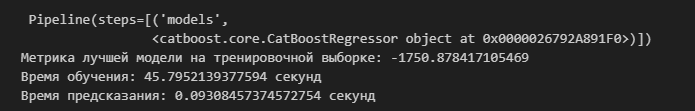

Значения DecisionTreeRegressor:

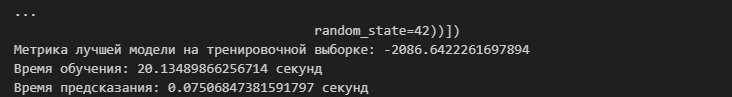


### Шаг 6. Проверка модели на тестовой выборке.

Считаю лучая модель CatBoostRegressor. Хоть и скорость ее обучения дольше так как ее точность выше, что важно для нашей задачи определения цены.

In [39]:

y_pred_test = optuna_search_catboost.predict(X_test)

rmse_test = rmse(y_test, y_pred_test)
print('RMSE на тестовой выборке:', rmse_test)

Object info sizes: 55771 9
RMSE на тестовой выборке: 1753.3384869589206


### Шаг 7. Общий вывод

**Вывод**

1. **Задача данного проекта была в определении лучшей модели для предсказания цены автомобиля.**

2. **В ходе предобработки данных были удалены пропуски и дубликаты, а так же удалены столбцы, которые слабо коррелировали с целевой переменной. Так же была применена функция оптимизации числовых данных. В ходе всех обработок, объем датасета стал 24 мб(изначально было 43 мб)**

3. **Лучшая модель оказалась CatBoostRegressor. Метрика rmse показала значение 1750. Хоть она и дольше обучается (46 секкунд), но в то же время предсказания точнее. Значение метрики на моделе DecisionTreeRegressor равняется 2086, время обучения 20 секунд.**

4. **Заказчику рекомендованно использовать CatBoostRegressor для более точного предсказания. В то же время, если важна скорость обучения, можно использовать DecisionTreeRegressor.**